In [32]:
import tensorflow as tf
import keras
import os
import numpy as np 
import pandas as pd
from pathlib import Path
from keras.preprocessing.image import ImageDataGenerator
import plotly.express as px
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint
from IPython.display import clear_output as cls

In [33]:
root_path = '/kaggle/input/animal-image-classification-dataset/Training Data/Training Data/'
class_names = ['Cat','Cow','Dog','Elephant', 'Gorilla', 'Hippo', 'Monkey']
n_classes = len(class_names)

class_dis = [len(os.listdir(root_path + name)) for name in class_names]

print(f"Total Number of Classes : {n_classes} \nClass Names : {class_names}")

Total Number of Classes : 7 
Class Names : ['Cat', 'Cow', 'Dog', 'Elephant', 'Gorilla', 'Hippo', 'Monkey']


In [34]:
fig = px.pie(names=class_names, values=class_dis, title="Training Class Distribution", hole=0.4)
fig.update_layout({'title':{'x':0.48}})
fig.show()

In [35]:
valid_path = '/kaggle/input/animal-image-classification-dataset/Validation Data/Validation Data/'

class_dis = [len(os.listdir(valid_path + name)) for name in class_names]

fig = px.pie(names=class_names, values=class_dis, title="Validation Class Distribution", color=class_names, hole=0.2)
fig.update_layout({'title':{'x':0.5}})
fig.show()

In [36]:
test_path = '/kaggle/input/animal-image-classification-dataset/Testing Data/Testing Data/'

class_dis = [len(os.listdir(test_path + name)) for name in class_names]

fig = px.pie(names=class_names, values=class_dis, title="Testing Class Distribution", color=class_names, hole=0.2)
fig.update_layout({'title':{'x':0.48}})
fig.show()

In [37]:
train_gen = ImageDataGenerator(rescale=1/255., rotation_range=10, horizontal_flip=True)
valid_gen = ImageDataGenerator(rescale=1/255.)
test_gen = ImageDataGenerator(rescale=1/255)

train_ds = train_gen.flow_from_directory(root_path, class_mode='categorical', target_size=(224,224), shuffle=True, batch_size=32, classes = class_names) 
valid_ds = valid_gen.flow_from_directory(valid_path, class_mode='categorical', target_size=(224,224), shuffle=True, batch_size=32, classes = class_names) 
test_ds = test_gen.flow_from_directory(test_path, class_mode='categorical', target_size=(224,224), shuffle=True, batch_size=32, classes = class_names)

Found 14000 images belonging to 7 classes.
Found 700 images belonging to 7 classes.
Found 1236 images belonging to 7 classes.


In [38]:
def plot_learning_curves(history, lr):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss'+" Lr = "+lr)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy'+" Lr = "+lr)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [39]:
def show_images(GRID=[5,5], model=None, size=(20,20), data=train_ds):
    n_rows = GRID[0]
    n_cols = GRID[1]
    n_images = n_cols * n_rows
    
    i = 1
    plt.figure(figsize=size)
    for images, labels in data:
        id = np.random.randint(len(images))
        image, label = images[id], class_names[np.argmax(labels[id])]
        
        plt.subplot(n_rows, n_cols, i)
        plt.imshow(image)
        
        if model is None:
            title = f"Class : {label}"
        else:
            pred = class_names[int(np.argmax(model.predict(image[np.newaxis, ...])))]
            title = f"Org : {label}, Pred : {pred}"
            cls()
            
        plt.title(title)
        plt.axis('off')
        
        i+=1
        if i>=(n_images+1):
            break
            
    plt.tight_layout()
    plt.show()

Epoch 1/15
438/438 [==============================] - 238s 468ms/step - loss: 1.8579 - accuracy: 0.3294 - val_loss: 1.6356 - val_accuracy: 0.3814
Epoch 2/15
438/438 [==============================] - 193s 440ms/step - loss: 1.5221 - accuracy: 0.4391 - val_loss: 2.2621 - val_accuracy: 0.2886
Epoch 3/15
438/438 [==============================] - 192s 438ms/step - loss: 1.3534 - accuracy: 0.5058 - val_loss: 4.8509 - val_accuracy: 0.1714
Epoch 4/15
438/438 [==============================] - 191s 436ms/step - loss: 1.1750 - accuracy: 0.5774 - val_loss: 2.1262 - val_accuracy: 0.3229
Epoch 5/15
438/438 [==============================] - 192s 439ms/step - loss: 1.0958 - accuracy: 0.6064 - val_loss: 2.2003 - val_accuracy: 0.3771
Epoch 6/15
438/438 [==============================] - 192s 438ms/step - loss: 1.0255 - accuracy: 0.6349 - val_loss: 1.9398 - val_accuracy: 0.3957
Epoch 7/15
438/438 [==============================] - 193s 441ms/step - loss: 1.0345 - accuracy: 0.6416 - val_loss: 2.2130 -

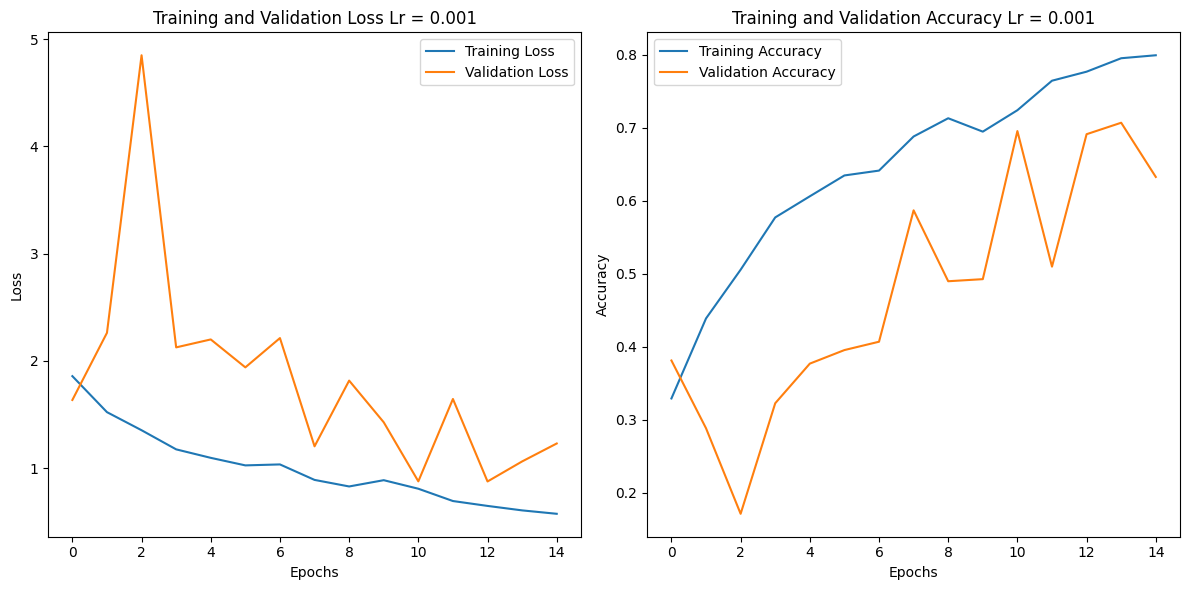

In [40]:
model_resnet50 = tf.keras.applications.resnet50.ResNet50(include_top=True,weights = None, classes=7, classifier_activation='softmax')
epochs = 15
model_resnet50.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model_checkpoint_callback  = tf.keras.callbacks.ModelCheckpoint(
        "/kaggle/working/resnet50_checkpoints/",
    monitor= 'val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode="max",
    save_freq='epoch',
)

history_resnet50 = model_resnet50.fit(
    train_ds,
    epochs=epochs,
    callbacks=[model_checkpoint_callback],
    validation_data=valid_ds,
    verbose=1
)
plot_learning_curves(history_resnet50, "0.001")

In [41]:
model = history_resnet50.model

In [42]:
loss_val, accuracy = model.evaluate(test_ds)
print("Loss value = ", loss_val)
print("accuracy = ", accuracy)

39/39 [==============================] - 4s 111ms/step - loss: 1.0228 - accuracy: 0.6853
Loss value =  1.0228198766708374
accuracy =  0.6852750778198242


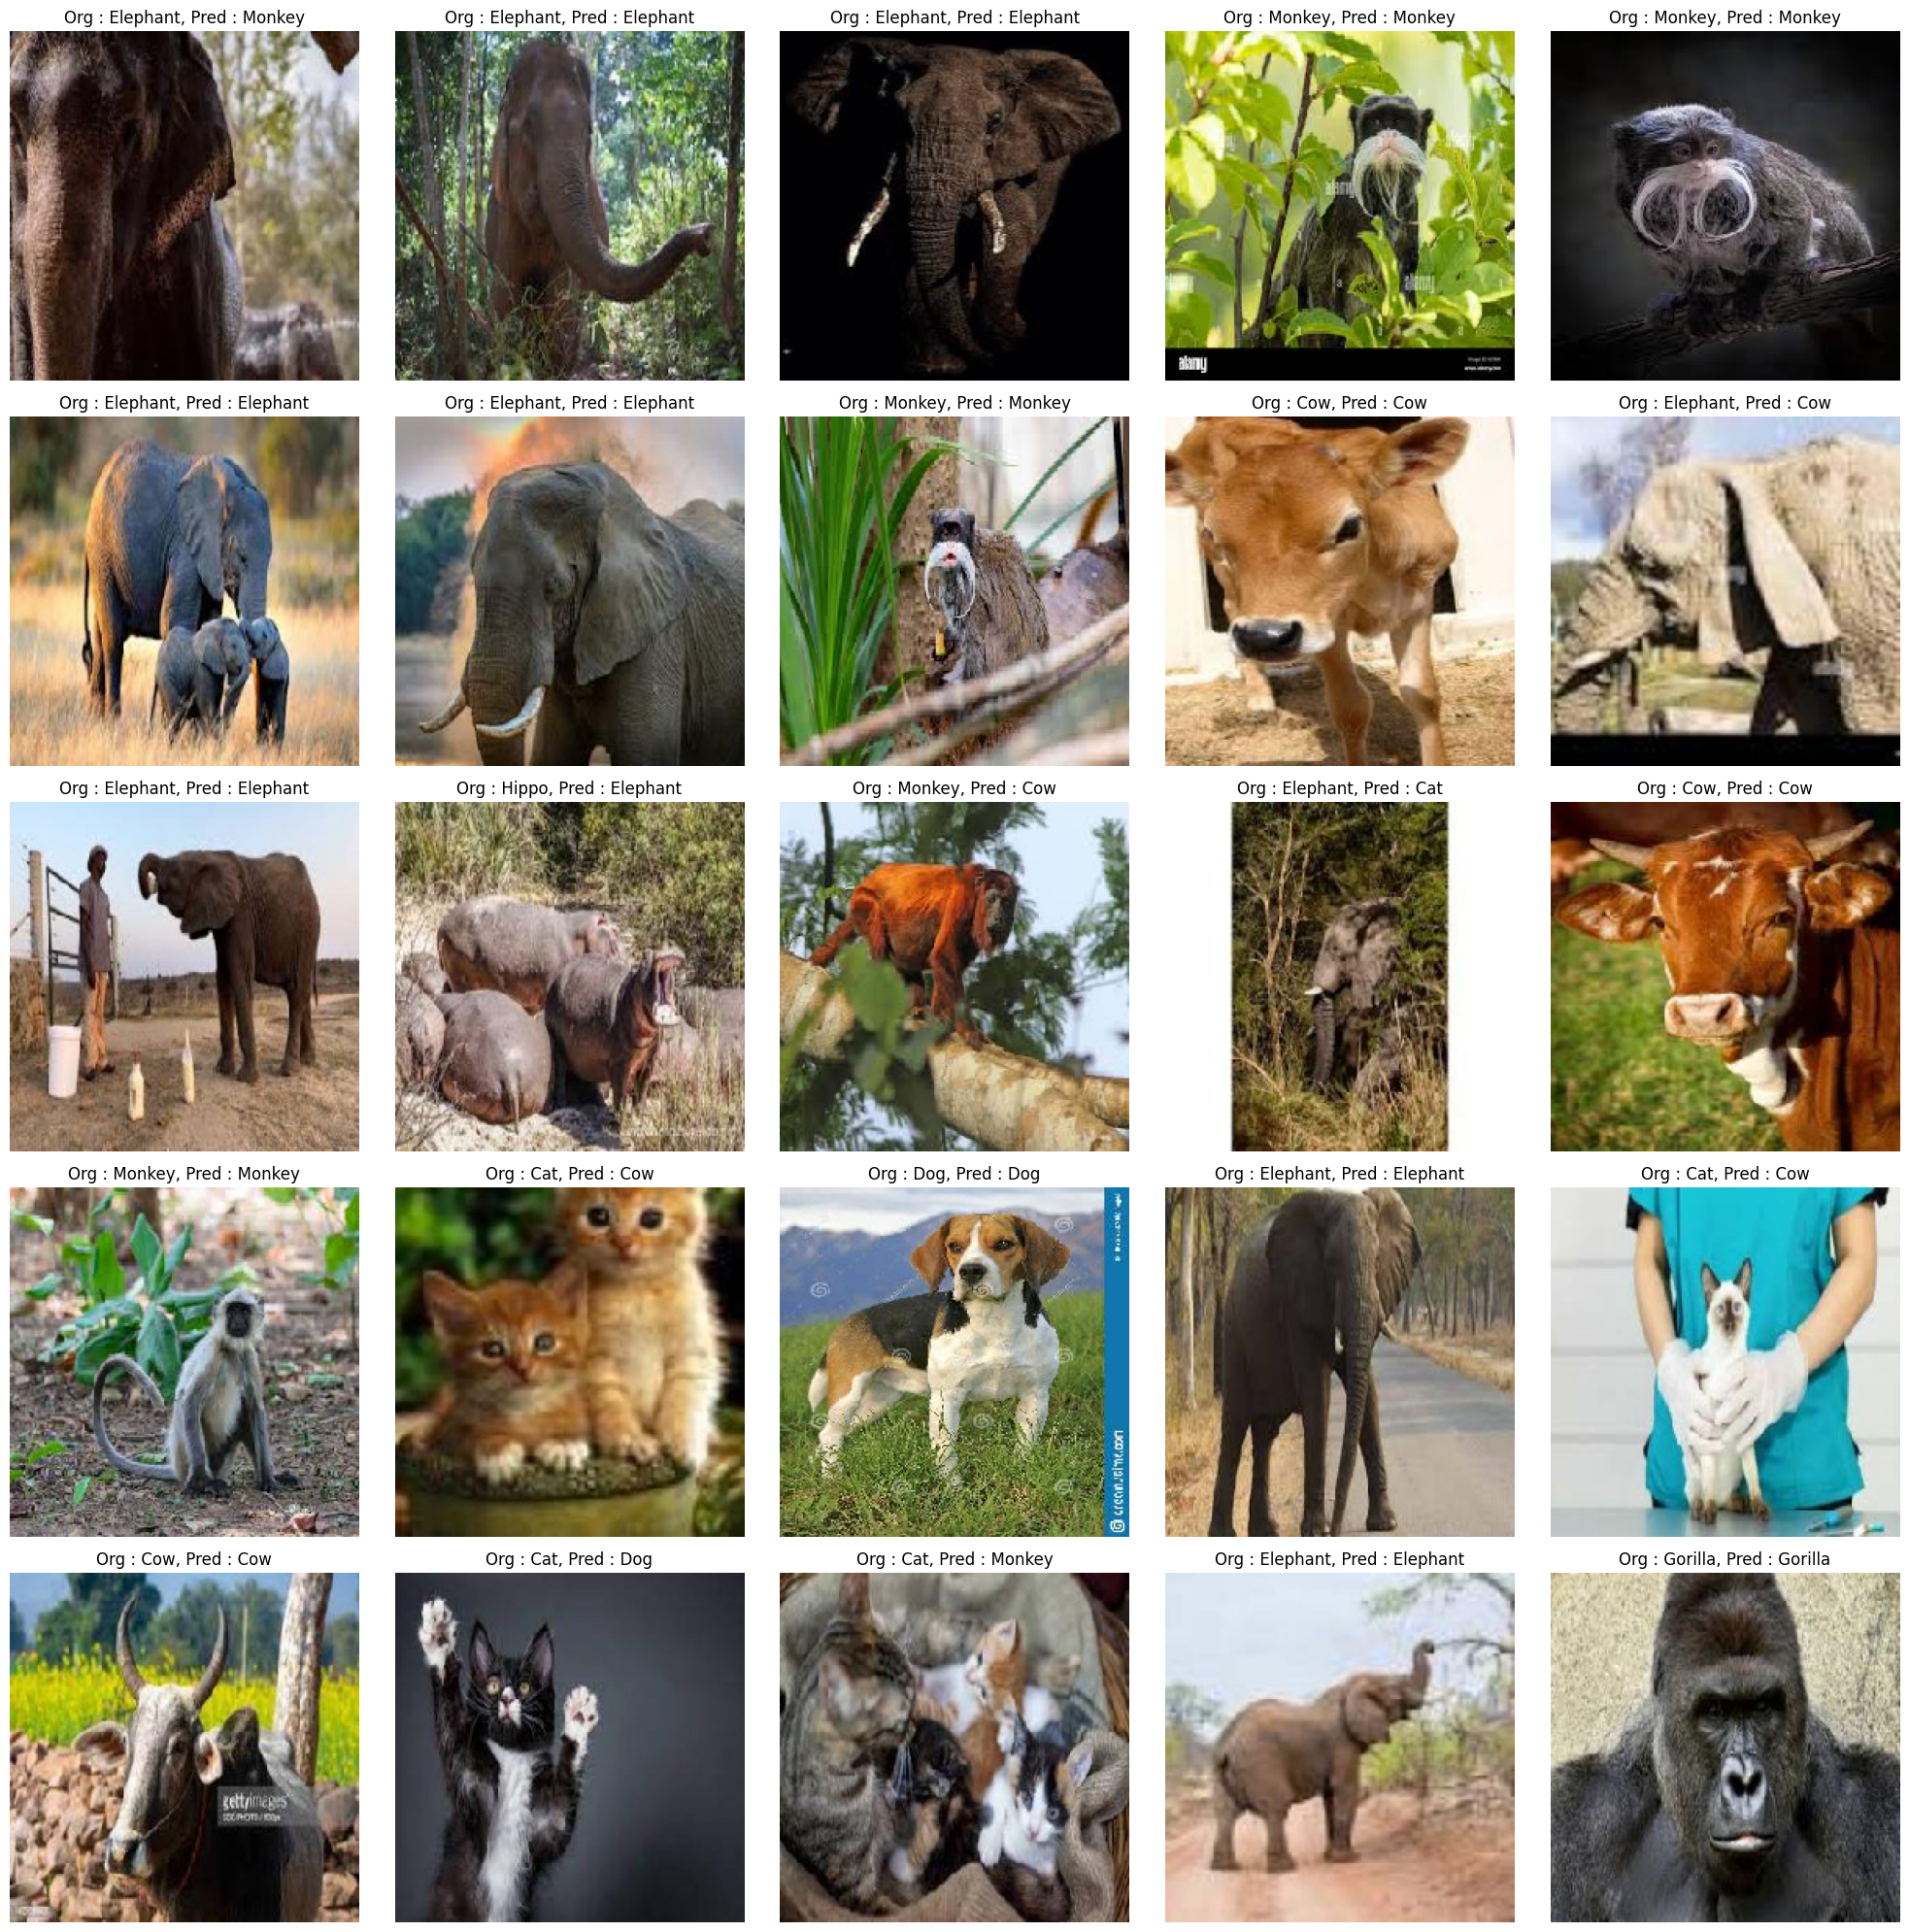

In [43]:
show_images(model=model, data=test_ds)

In [44]:
from sklearn.metrics import f1_score, classification_report

def calculate_f1_score_batch(model, images, labels):
    y_true = np.argmax(labels, axis=1)
    y_pred = np.argmax(model.predict(images), axis=1)

    f1_scores = f1_score(y_true, y_pred, average=None)
    avg_f1_score = f1_score(y_true, y_pred, average='weighted')  
    return f1_scores, avg_f1_score


1/1 [==============================] - 0s 30ms/step
F1 Scores for Model 1 (one batch): [0.8        0.5        0.5        0.75       0.57142857 0.57142857
 0.58823529]
Average F1 Score for Model 1 (one batch): 0.622203256302521


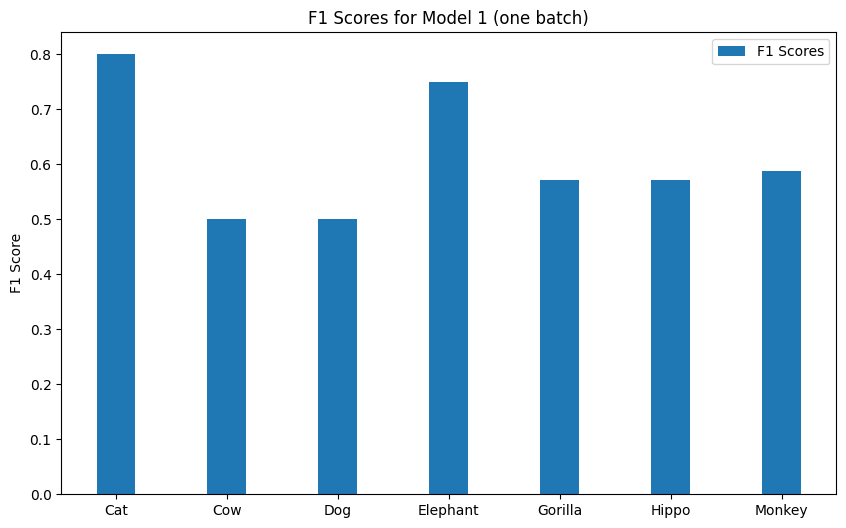

In [45]:
images_batch, labels_batch = next(iter(valid_ds))

f1_scores_batch, avg_f1_batch = calculate_f1_score_batch(model, images_batch, labels_batch)

print("F1 Scores for Model 1 (one batch):", f1_scores_batch)
print("Average F1 Score for Model 1 (one batch):", avg_f1_batch)

def plot_f1_scores_bar(f1_scores, class_names, title):
    fig, ax = plt.subplots(figsize=(10, 6))
    width = 0.35
    ind = np.arange(len(class_names))

    rects1 = ax.bar(ind, f1_scores, width, label='F1 Scores')

    ax.set_xticks(ind)
    ax.set_xticklabels(class_names)
    ax.legend()

    ax.set_ylabel('F1 Score')
    ax.set_title(title)

    plt.show()

plot_f1_scores_bar(f1_scores_batch, class_names, 'F1 Scores for Model 1 (one batch)')


In [46]:
model.save("ResNet_7.h5")
model.save("ResNet_7.keras")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

